# Import Dependencies

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Set Variables

In [31]:
CULL_FRACTION = 1 #amount of dataset to use
TRAIN_FRACTION = 0.8 #train fraction
LOAD = False #tries to load existing model
EPOCHS = 2500
SAMPLES = 10000 #no of samples to generate
model_path = "models/model.pkl"

# Load Dataset

In [32]:
df = pd.read_csv("real_data.csv").set_index("building_id")  

# Pre Processing

In [33]:
cull_df = df.sample(frac=CULL_FRACTION).reset_index(drop=True)

train_data, test_data = train_test_split(cull_df, train_size=TRAIN_FRACTION)

print(train_data.shape, test_data.shape)

(1257, 7) (315, 7)


# GAN Training

In [34]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train_data) 

if LOAD:
    synthesizer = CTGANSynthesizer.load(filepath=model_path)
else:
    synthesizer = CTGANSynthesizer(
        metadata,
        enforce_rounding=True,
        enforce_min_max_values=True,
        epochs=EPOCHS,
        verbose=True
    )
    synthesizer.fit(train_data)

C:\Users\raaja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:86: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-0.11) | Discrim. (-0.15): 100%|█████████████████████████████████████████████| 2500/2500 [02:39<00:00, 15.71it/s]


In [35]:
samples = synthesizer.sample(
    num_rows=SAMPLES,
    batch_size=1000
)
samples

Sampling rows: 100%|██████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16758.25it/s]


,building_type,sqft,yearbuilt,numberoffloors,airTemperature,humidity,power_consumption
0,Lab Building,21578.0,1962.0,6.0,9.772727,76.991768,50.011391
1,Education,2759.0,1980.0,1.0,14.823685,71.788919,8.621108
2,Parking: Enclosed Garage,85915.0,1962.0,6.0,11.856708,63.322191,191.781393
3,Office,56650.0,1926.0,5.0,10.841085,70.918887,33.137591
4,Public services,186946.0,1914.0,7.0,14.983608,70.984200,91.084929
...,...,...,...,...,...,...,...
9995,Police Station,39135.0,1961.0,7.0,15.885561,62.448908,78.529552
9996,Public Service,13514.0,1979.0,8.0,10.824035,62.687976,0.019732
9997,Maintenance Repair Shop,199351.0,1936.0,21.0,9.065732,63.611535,145.601447
9998,Theater,132947.0,1922.0,16.0,15.173913,62.754567,34.531913


# Evaluation

In [36]:
eval_real = test_data.copy()
eval_fake = samples.copy()

le = LabelEncoder()
eval_real['building_type'] = le.fit_transform(test_data['building_type'])
eval_fake['building_type'] = le.fit_transform(samples['building_type'])

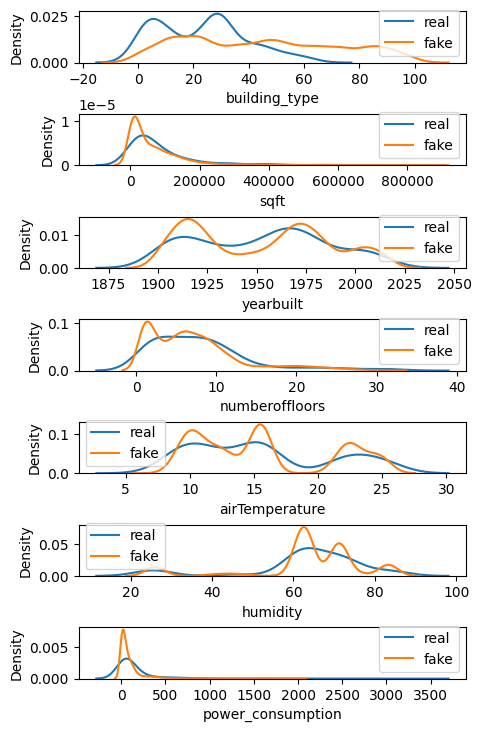

In [37]:
fig = plt.figure(figsize=(5,10))
fig.subplots_adjust(hspace=1, wspace=0.4)

for n,cat in enumerate(eval_real.columns):
    ax = fig.add_subplot(8, 1, n+1)
    sns.kdeplot(eval_real[cat], label = 'real', ax=ax)
    sns.kdeplot(eval_fake[cat], label = 'fake', ax = ax)
    plt.legend()

<Axes: >

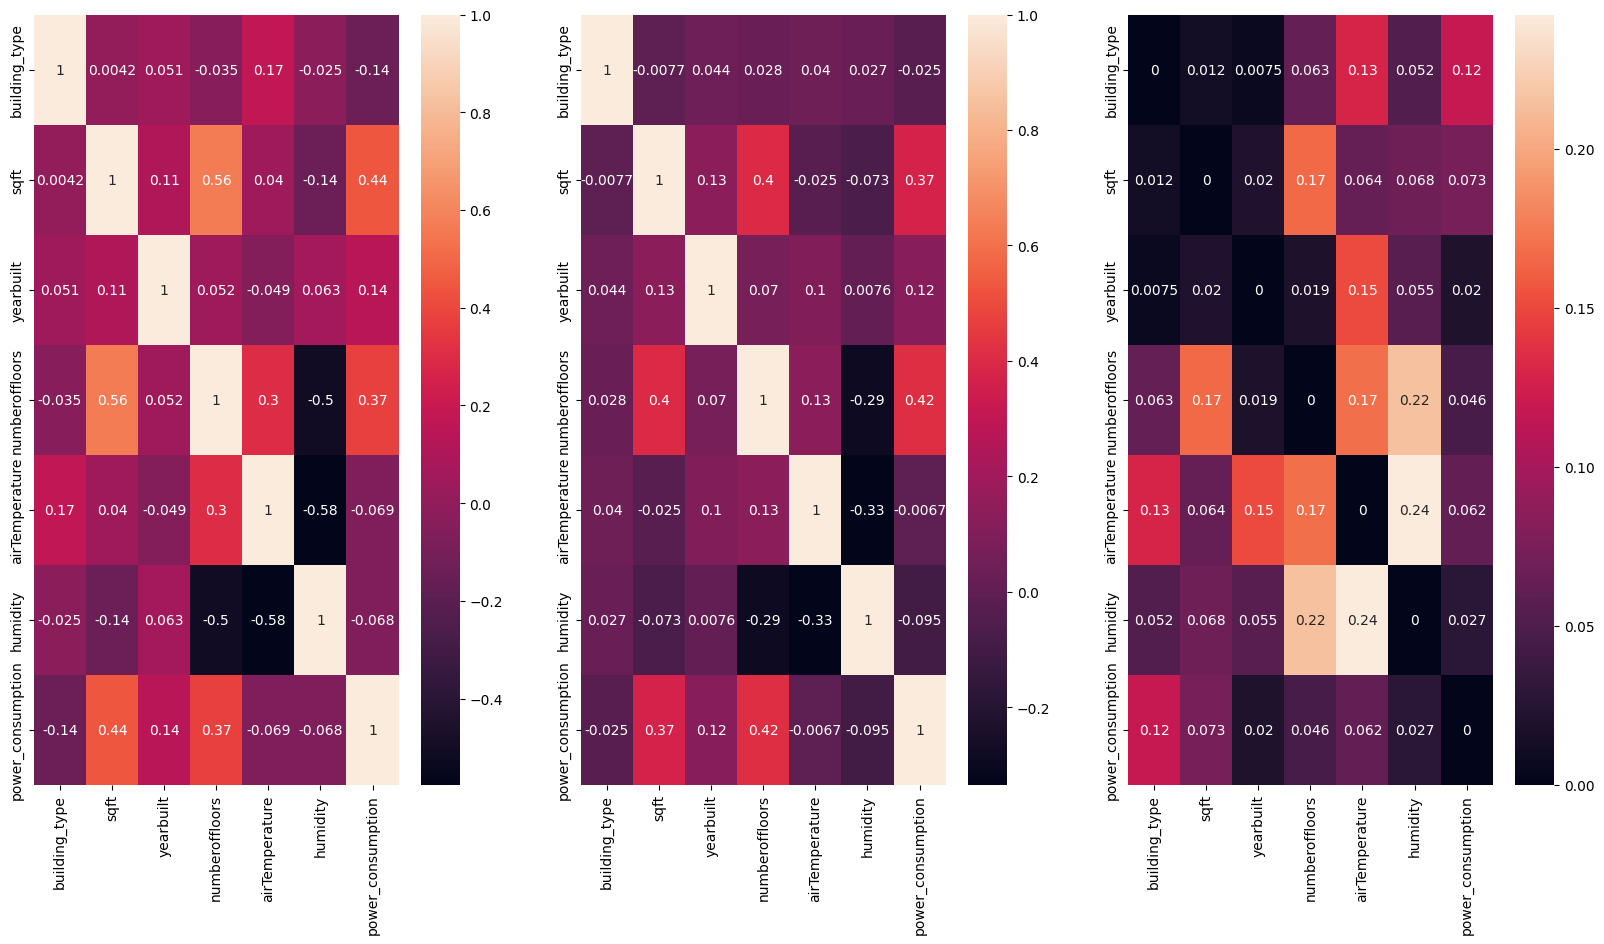

In [38]:
fig_corr = plt.figure(figsize=(20,10))
ax = fig_corr.add_subplot(1, 3, 1)
sns.heatmap(eval_real.corr(), annot=True, ax=ax)
ax = fig_corr.add_subplot(1, 3, 2)
sns.heatmap(eval_fake.corr(), annot=True, ax=ax)
ax = fig_corr.add_subplot(1, 3, 3)
sns.heatmap(abs(eval_real.corr()-eval_fake.corr()), annot=True, ax=ax)

# Save Model

In [39]:
synthesizer.save(filepath=model_path)

# Save Generated Dataset

In [40]:
samples.to_csv("generated_data.csv")